## Brief Introduction
In this notebook, I experimennt the visualization of Ranking Metrics for the Anomaly Detection Model after PCA. The problem is set up as "Unsupervised Anomaly Detection". I split the dataset into the Validation and Testing Dataset. 

The anomaly in the datast is a figure with mustache.

Data Source: http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

In [10]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random
from random import shuffle

from support_functions import *

## Import Dataset

In [15]:
# Define the images to be read and the corresponding labels
label_1_folder = [9,21]
target_folders = range(1,22)
data_path = "Yale Face B/CroppedYale/"

# We also need to reduce the size of the image for the convenience of computation
reduce_height = 24
reduce_width = 21

# Read the images and reduce the size
images,labels = read_images(data_path,target_folders,label_1_folder,reduce_height,reduce_width)

# To evaluate the threshold of the dark pixels
# dark_pixel_curve(images)

imgs = images[:] # Create a copy
# Eliminate the images and labels whose number of dark pixels are above the threshold
# The threshold is determined based on the dark_pixel_curve() function above
imgs,labels,remove_count = remove_dark_img(imgs,labels,180) 

# Visualization of images and labels
# plot_images(imgs,labels)

# Randomly select and show anomalous images
# show_anomaly_images(imgs,labels)

574  images are above our threshold and thus removed from the list


## Apply PCA on the Normal Images for Dimension Reduction

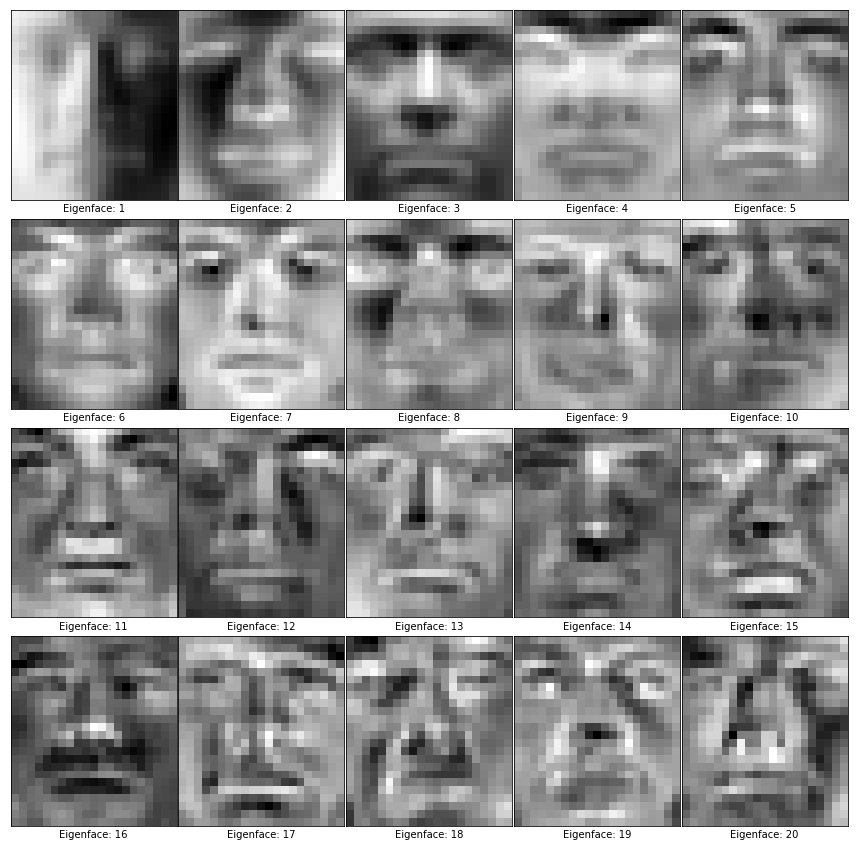

In [16]:
# Define the number of Principal Components to keep from the image
n_components  = 20

# Find the dimension of one image
height, width = imgs[0].shape
num_imgs = len(imgs)
# height, width,num_imgs

# Initialize the matrix to store the entire image list
imgs_matrix = np.zeros((height*width,num_imgs)) 

# Iterate through each image, convert it into an array, and add to the imgs_matrix as a column
for i in range(0,len(imgs)):
    imgs_matrix[:,i] = imgs[i].reshape(height*width)
# imgs_matrix.shape

# Vectorize the labels list
labels_vector = np.hstack(labels) # Easier to get multiple items from a vector than from a list

# Select only the Normal Image Dataset
imgs_matrix_normal = imgs_matrix[:,labels_vector == 0]
# imgs_matrix_normal.shape

# Take a Mean-Shift - With only the Normal Data
img_matrix_shifted_normal, component_mean_normal = mean_shift(imgs_matrix_normal)

# Compute the Covariance Matrix of the Image Matrix - With only the Normal Data
cov_matrix = np.cov(img_matrix_shifted_normal)

# Compute the eigen value and eigen vectors
eigen_value, eigen_vector = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
# First make a list of (eigenvalue, eigenvector) tuples 
eig_pairs = [(np.abs(eigen_value[i]), eigen_vector[:,i]) for i in range(len(eigen_value))] 
# Sort the (eigenvalue, eigenvector) tuples from high to low 
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Convert the sorted eigen vector list to matrix form
eigen_vector_sorted = np.zeros((height*width,n_components))
for i in range(0,n_components):
    eigen_vector_sorted[:,i] = eig_pairs[i][1]
    
# Cut the sorted eigenvectors by columns to get the transformational matrix for PCA
pca_matrix = eigen_vector_sorted[:,:n_components]

# Visualize the eigenfaces with the pca matrix
plot_eigenfaces(pca_matrix,height, width)

### Reconstruct the Face Images after PCA - *With only the Normal Data*
First we applies PCA on the image data matrix to downsize its dimensions. Then we reconstruct the image matrix through the PCA matrix and add the mean of each component back. Finally we plot several examples to compare the original face images with the reconstructed face images.

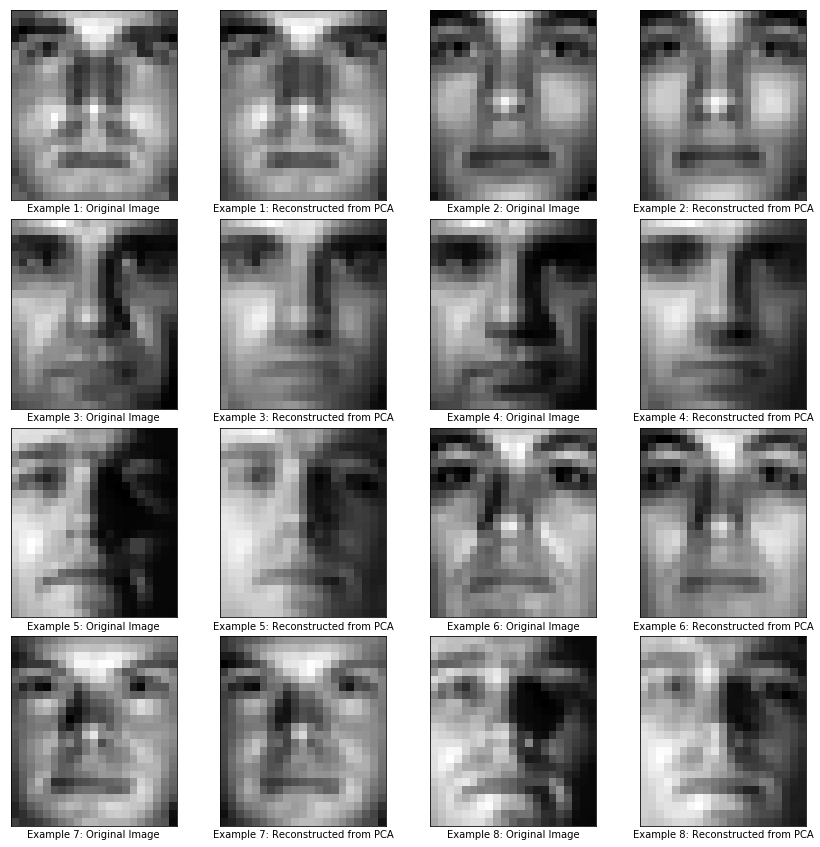

In [17]:
# Compute the transformed image
# Shape of pca_matrix: n * k
# Shape of imgs_matrix: n * m
# Shape of the transformed face image matrix: k * m
img_pca_tranf_normal = pca_matrix.T.dot(img_matrix_shifted_normal)

# Reconstruct through PCA Matrix and Mean Vector
# Shape of the reconstructed face image matrix: n * m
# component_mean is a vector and we need to convert it to a one-column matrix for the addition
img_matrix_reconst_normal = pca_matrix.dot(img_pca_tranf_normal) + component_mean_normal.reshape(height*width,1)

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(img_matrix_reconst_normal,imgs_matrix_normal,height,width)

## Anomaly Detection with Multivariate Gaussian Method
### Apply PCA Matrix on All the Data (Normal and Anomalous)
Use the PCA Matrix generated from only the Normal Dataset

In [20]:
# Mean Shift
img_matrix_shifted_all, component_mean_all = mean_shift(imgs_matrix)

# Compute the transformed image
# Shape of pca_matrix: n * k
# Shape of imgs_matrix: n * m
# Shape of the transformed face image matrix: k * m
img_pca_tranf_all = pca_matrix.T.dot(img_matrix_shifted_all)

### Split the Data into the Validation and Test Set
With the function, we get the indice of images to be assigned to the Validation and Testing set

In [64]:
# Split the images and labels
ratio_train = 0 # No training set
ratio_val = 0.6 # 60% into the validation set
train_ind, val_ind, test_ind = split_train_eval_test(labels_vector,ratio_train,ratio_val)

imgs_train = img_pca_tranf_all[:,train_ind]
imgs_val = img_pca_tranf_all[:,val_ind]
imgs_test = img_pca_tranf_all[:,test_ind]
labels_train = labels_vector[train_ind]
labels_val = labels_vector[val_ind]
labels_test = labels_vector[test_ind]

imgs_train.shape, imgs_val.shape,imgs_test.shape, labels_train.shape,labels_val.shape,labels_test.shape

((20, 0), (20, 401), (20, 268), (0,), (401,), (268,))

### Apply Multivariate Gaussian Distribution on the Validation Set

In [71]:
# Get Gaussian Distribution Model for the Validation Data
# Note: fit_multivariate_gaussian() is my own coded function
dist = fit_multivariate_gaussian(imgs_val.T)
# dist = fit_multivariate_gaussian(img_pca_tranf_all.T)

# Get Probability of being Anomaly vs. being Normal
p_val = dist.pdf(imgs_val.T)   # Probability of Being Normal

# Sort the Images and Labels based on the Probability
rank = np.argsort(p_val) # Sort from the Smallest to the Largest
imgs_val_ranked = imgs_val[:,rank]
labels_val_ranked = labels_val[rank]

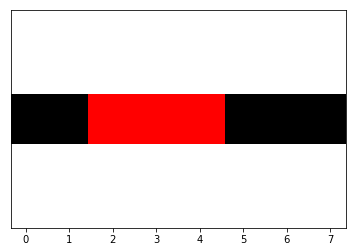

In [100]:
import matplotlib.pyplot as plt
import numpy.ma as ma

a = np.array([1,1,1,1,1,1,1,1])
labels = np.array([0,0,1,1,1,0,0,0])

a_negative = labels == 0
a_masked = ma.masked_where(a_negative, a)
# use a masked array to suppress the values that are too low
# a_masked = np.ma.masked_less_equal(a, 15)

# plot the full line
plt.plot(a, 'k',linewidth=50)

# plot the masked as red
plt.plot(a_masked, 'r', linewidth=50)

# Remove y axis
plt.yticks([])

plt.show()

In [86]:
import matplotlib.pyplot as plt
import numpy.ma as ma

a = np.array([1,1,1,1,1,1,1,1])
labels = np.array([0,0,1,1,1,0,0,0])

a_negative = labels == 0
a_masked = ma.masked_where(a_negative, a)
# use a masked array to suppress the values that are too low
# a_masked = np.ma.masked_less_equal(a, 15)

# plot the full line
plt.plot(a, 'k',linewidth=50)

# plot the masked as red
plt.plot(a_masked, 'r', linewidth=50)

# Remove y axis
plt.yticks([])

plt.show()

array([False, False,  True,  True,  True, False, False, False], dtype=bool)